In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
from importlib import reload

import os
import sys
import re
import glob
import time
import pickle
import scipy.ndimage as ndi
from itertools import islice
import IPython
import logging
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchmore import layers, flex
import torchtrainers as tt
from torch.utils.data import DataLoader
from webdataset import WebDataset, WebLoader
from ocrlib import ocrhelpers as helpers
from ocrlib import ocrmodels2 as models
from ocrlib.ocrhelpers import method, asnp
import matplotlib.pyplot as plt
from random import randrange
import imageio.v2 as imageio
import gzip
from ocrlib import nlbin

plt.rc("image", cmap="gray")
plt.rc("image", interpolation="nearest")

def RUN(x): print(x, ":", os.popen(x).read().strip())
    
RUN("date"); RUN("hostname"); RUN("nvidia-smi -L"); RUN("pwd")

if "GOPEN_VERBOSE" in os.environ:
    del os.environ["GOPEN_VERBOSE"]


date : Wed Apr 26 17:12:51 PDT 2023
hostname : bragi
nvidia-smi -L : GPU 0: NVIDIA TITAN X (Pascal) (UUID: GPU-a964bb9a-cb1a-5036-e1d8-1217c1faa8e7)
GPU 1: NVIDIA TITAN X (Pascal) (UUID: GPU-a16b9686-b668-e8d5-ff5f-f85aea86d034)
pwd : /home/tmb/tutorials/icdar2023-worksheets


In [3]:
training_urls = "gs://ocro-iaa/segs/books-{000000..000653}-segs.tar"
batch_size = 2
mname = "seg_unet_v2"

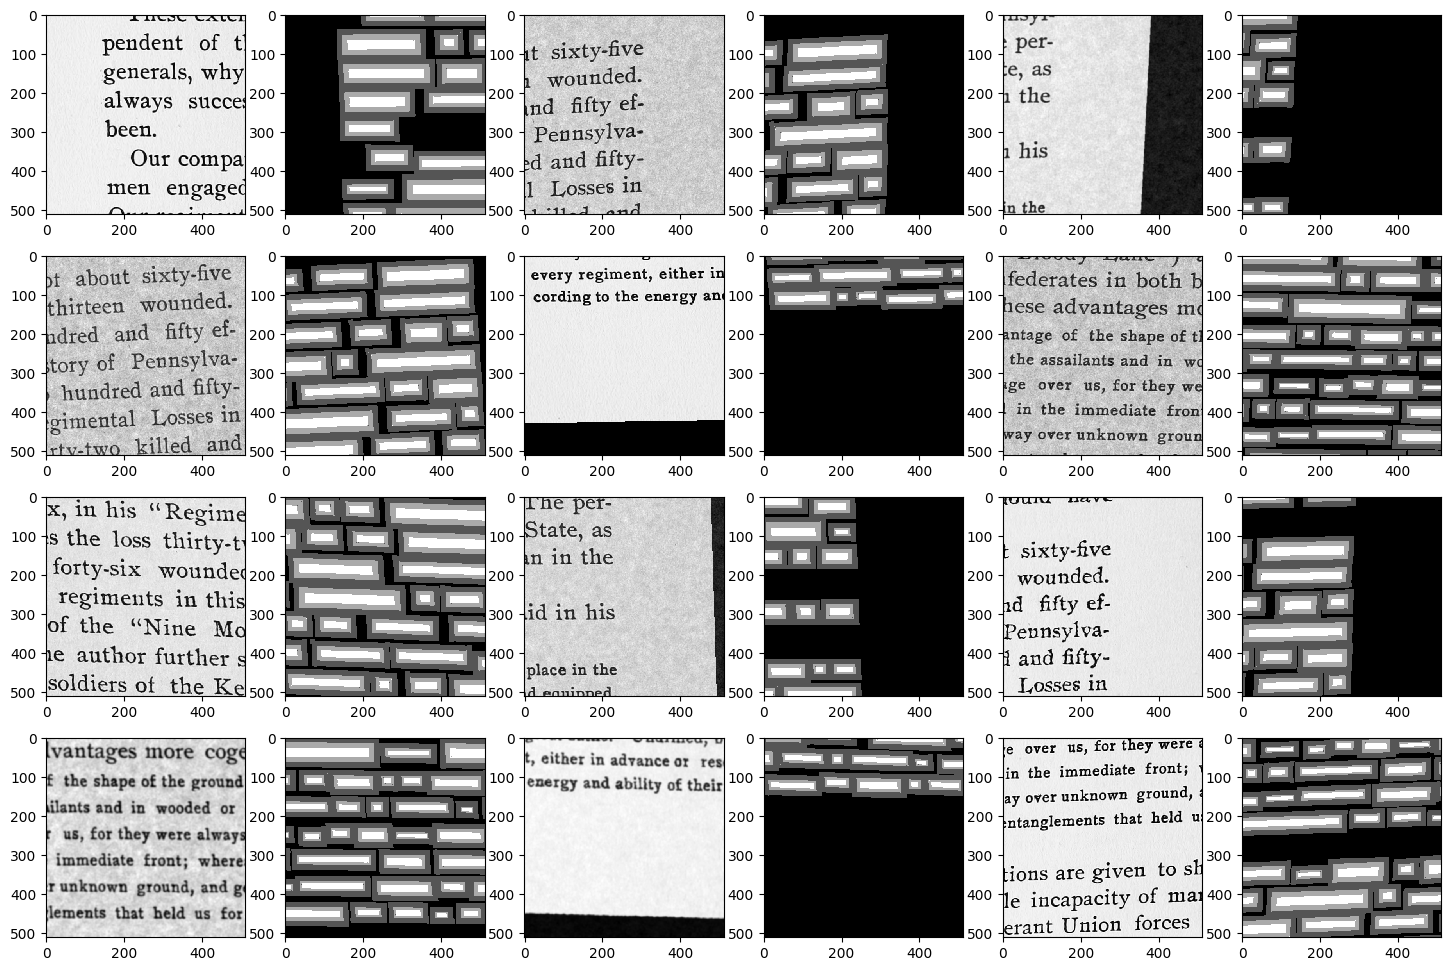

In [4]:
from ocrlib.ocraugment import maybe, normalize, noisify, threshold, distort

def random_patch(images, orders, size=512):
    h, w = images[0].shape[:2]
    for image in images:
        assert image.shape[:2] == (h, w)
    matrix = np.eye(3)
    matrix[:2, :2] += np.random.randn(2, 2) * 0.03
    # pick the translation so that we get a patch from anywhere within the image
    matrix[0, 2] = -random.uniform(-size/2, h - size/2)
    matrix[1, 2] = -random.uniform(-size/2, w - size/2)
    # compute the transform from the image to the patch
    matrix = np.linalg.inv(matrix)
    # apply the affine transform
    patches = []
    for image, order in zip(images, orders):
        patch = ndi.affine_transform(image, matrix, output_shape=(size, size), order=order, mode="constant", cval=0)
        patches.append(patch)
    return patches

def random_patch_simple(images, size=512):
    h, w = images[0].shape[:2]
    for image in images:
        assert image.shape[:2] == (h, w)
    y = randrange(0, h - size)
    x = randrange(0, w - size)
    patches = []
    for image in images:
        patches.append(image[y : y + size, x : x + size])
    return patches

def get_patches(sample, size=512):
    global last_img, last_seg
    image1 = sample["jpg"]
    assert image1.ndim == 2
    image1 = image1.astype(np.float32) / 255.0
    if maybe(0.1): # FIXME only for testing
        binarized = nlbin.nlbin(image1)
        if maybe(0.2):
            binarized = (binarized > 0.5).astype(np.float32)
        # binarization sometimes changes image size slightly
        assert np.amax(np.abs(np.array(binarized.shape) - np.array(image1.shape))) <= 2
        # use ndi.affine_transform to make binarized exactly the same shape as image1
        image1 = ndi.affine_transform(binarized, np.eye(3), output_shape=image1.shape, order=0, mode="nearest")
    seg1 = sample["words.jpg"].clip(0, 3)
    mask = ndi.maximum_filter(seg1 == 1, 12)
    seg1 = np.maximum(seg1, mask)
    assert seg1.ndim == 2
    if np.amax(seg1) < 3:
        return
    if image1.shape[0] < size or image1.shape[1] < size:
        return
    for i in range(32):
        # TODO: add 90 degree rotations to augmentations
        # TODO: do something about isolated characters
        last_img, last_seg = img, seg = random_patch([image1, seg1], [1, 0], size=size)
        if maybe(0.05):
            img = threshold(img)
        if maybe(0.5):
            img = distort(img)
        if maybe(0.5):
            img = normalize(img)
        if maybe(0.5):
            img = noisify(img)
        if maybe(0.1):
            sigma = random.uniform(0.5, 2.0)
            img = ndi.gaussian_filter(img, sigma)
        if np.amax(seg) < 3:
            continue
        yield (img, seg)

sample = pickle.load(gzip.open("pageseg.pkl.gz", "rb"))
figsize(18, 12)
for i, (img, seg) in enumerate(get_patches(sample)):
    if i >= 12:
        break
    subplot(4, 6,2*i + 1)
    imshow(img)
    subplot(4, 6, 2*i + 2)
    imshow(normalize(seg))

In [5]:

def expand_patches(src):
    for patch in src:
        for result in get_patches(patch):
            yield result

def usm_patch(img):
    img = img - ndi.gaussian_filter(img, 16.0, mode="nearest")
    return img

def img_tensor(img):
    assert img.ndim == 2, img.shape
    assert img.dtype == np.float32, img.dtype
    assert np.amax(img) < 10.0  # make sure it already got normalied somewhere
    return torch.tensor(img).unsqueeze(0)

def label_tensor(label):
    assert img.ndim == 2, img.shape
    assert label.dtype == np.uint8, label.dtype
    assert np.amax(label) < 4
    return torch.tensor(label).long()

def pipeline(ds):
    return ds.decode("l8").compose(expand_patches).map_tuple(usm_patch).map_tuple(img_tensor, label_tensor)

training = pipeline(WebDataset(training_urls, resampled=True).shuffle(1000)).shuffle(1000).batched(batch_size)
training_dl = WebLoader(training, batch_size=None, num_workers=4, pin_memory=True).with_epoch(10000//batch_size)

In [6]:
device = "cuda:0"
model = models.make(mname)
model.to(device);
print(str(model)[:200],"\n...\n", str(model)[-200:])

Sequential(
  (0): SegInput()
  (1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): ReLU 
...
 ing_stats=True)
  (16): ReLU()
  (17): BDHW_LSTM(
    (hlstm): LSTM(64, 4, bidirectional=True)
    (vlstm): LSTM(8, 4, bidirectional=True)
  )
  (18): Conv2d(8, 4, kernel_size=(5, 5), stride=(1, 1))
)


In [7]:
trainer = helpers.SegTrainer(model, masked=-1, device=device)
trainer.load_best()

no load file found


False

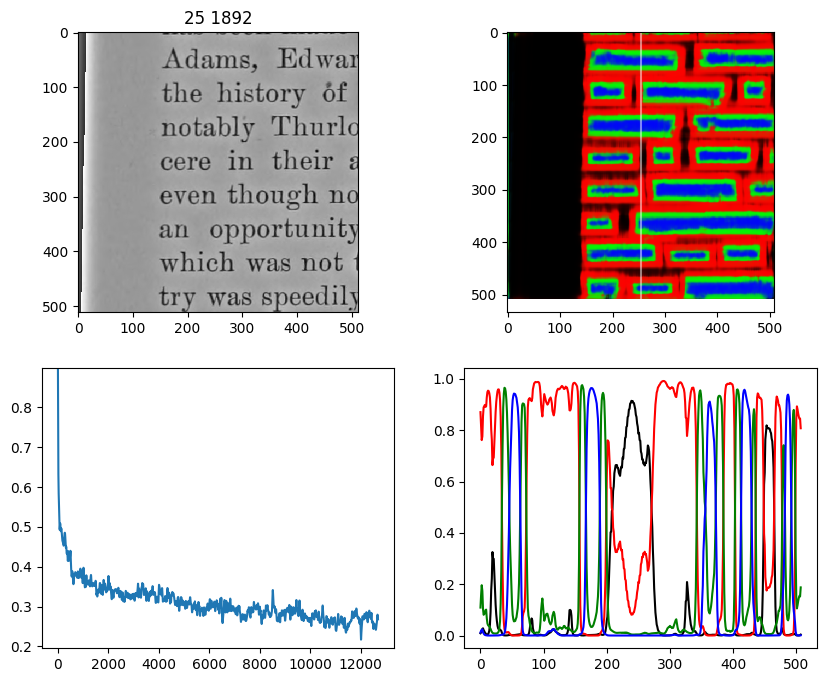

In [8]:
trainer.train(training_dl, learning_rates=[1e-3]+[1e-4]*200, every=10)